# Titanic: Machine Learning from Disaster
## Bibliotecas utilizadas

In [1]:
from numbers import Number

import pandas as pd
%matplotlib inline

## Lendo o arquivo e exibindo suas extremidades

In [2]:
csv_train = pd.read_csv('datasets/train.csv')
csv_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
csv_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


## Criando um novo dataframe
Esse novo dataframe terá apenas as colunas úteis para modelagem. Serão removidos o nome e o número do ticket, PassengerId será colocado como índice e as variáveis Sex e Embarked serão transformadas em dummy

In [4]:
train = csv_train.copy()  # Cria uma cópia do dataframe
train.set_index('PassengerId', inplace=True)  # Define PassengerId como novo índice das linhas
dummies = pd.get_dummies(train.loc[:, ['Sex', 'Embarked']])  # transforma Sex e Embarked em variáveis dummy
train = pd.concat([train, dummies], axis=1)  # Concatena train e dummies
train.drop(['Sex', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)  # Remove colunas inúteis

# Criando a variável cabin_type
O número da cabine, por si só, não é uma informação muito útil. Porém a letra inicial da cabine pode ser um indicativo da localização da mesma e isso pode indicar o 'status' do passageiro que ocupa aquela cabine. Dessa forma vamos isolar a primeira letra da cabine e chamá-la de CabinType

In [5]:
def gera_CabinType(cabin):
    if isinstance(cabin, Number):
        return 'X'
    elif ' ' in cabin:  # Mais de uma cabine
        cabins = cabin.split()  # Separa todas as cabines em uma lista
        cabins = [c[0] for c in cabins]  # Pega o primeiro caractere de cada cabine
        return ''.join(set(cabins))  # Remove duplicatas e junta todos os CabinTypes
    else:
        return cabin[0]

cabin_types = train['Cabin'].apply(gera_CabinType)
cabin_types.name = 'Cabin_Type'
train = pd.concat([train, cabin_types], axis=1)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_Type
PassengerId,,,,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,NaN,0,1,0,0,1,X
2,1,1,38.0,1,0,71.2833,C85,1,0,1,0,0,C
3,1,3,26.0,0,0,7.9250,NaN,1,0,0,0,1,X
4,1,1,35.0,1,0,53.1000,C123,1,0,0,0,1,C
5,0,3,35.0,0,0,8.0500,NaN,0,1,0,0,1,X


## Analisando valores missing em Cabin
Comparando o preço e a classe dos passageiros sem número de cabine (ou com CabinType 'X')

In [6]:
def gera_preços(df):
    return pd.DataFrame({'Valor mínimo': df.Fare.min(),
            'Valor médio': df.Fare.mean(),
            'Valor máximo': df.Fare.max(),
            }, index=[len(df.Fare)])

train.groupby('Cabin_Type').apply(func=gera_preços)

,,Valor máximo,Valor médio,Valor mínimo
Cabin_Type,,,,
A,15,81.8583,39.623887,0.0000
B,47,512.3292,113.505764,0.0000
C,59,263.0000,100.151341,26.5500
D,33,113.2750,57.244576,12.8750
E,32,134.5000,46.026694,8.0500
F,9,39.0000,21.972222,7.7500
FE,1,22.3583,22.358300,22.3583
FG,3,7.6500,7.650000,7.6500
G,4,16.7000,13.581250,10.4625


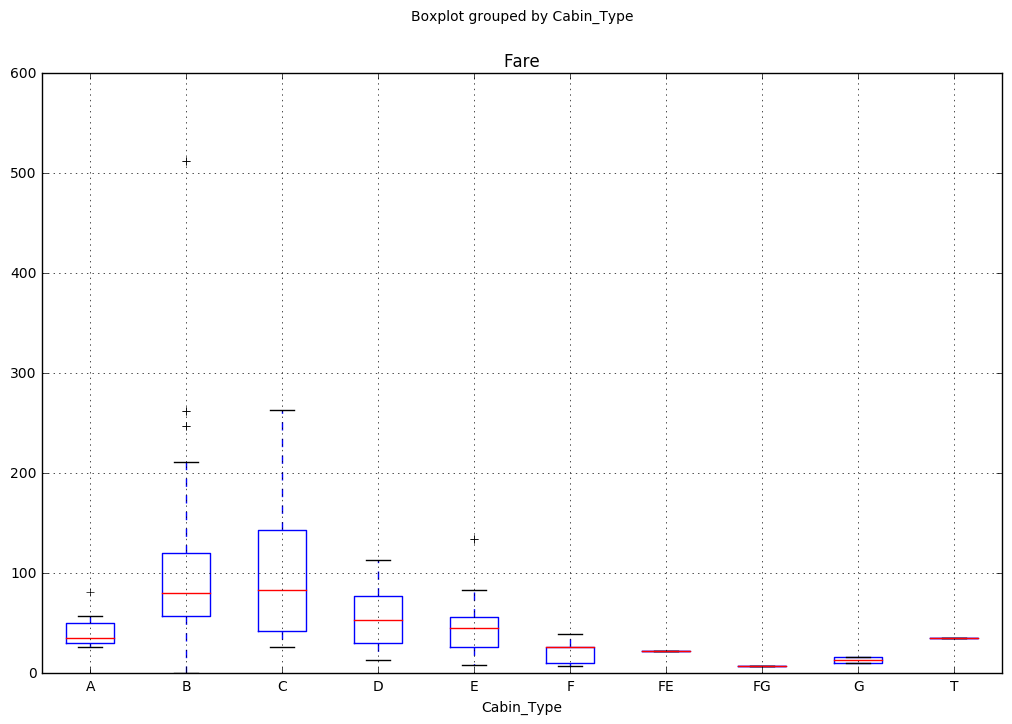

In [7]:
com_cabine = train.loc[train.Cabin.notnull(), :]
com_cabine.boxplot('Fare', by='Cabin_Type', figsize=(12, 8))

**É possível ver que há evidências de uma relação entre CabinType e Fare. Vou testar isso com uma ANOVA**

In [8]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('Fare ~ Cabin_Type', data=com_cabine).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                   sum_sq     df         F    PR(>F)
Cabin_Type  221117.561353    9.0  5.282336  0.000002
Residual    902311.304144  194.0       NaN       NaN


Há uma diferença significativa das médias de ```Fare``` para os diversos grupos de ```CabinType```. Dessa forma é possível gerar um modelo que encontre o ```CabinType``` em função do ```Fare```

## Próximo passo: prever o tipo de cabine